# siboire-plaato-data-exploration
Exploration and comparison of fermentation data from Plaato probes compared to manual measurements


## Requirements
Python 3.6+ with the following packages:
- pandas, numpy, matplotlib, seaborn
- requests
- python-dotenv

Inside a virtual environment, run:
```
pip install -r requirements.txt
```

## Project strucure
- `data/`: contains the raw data files fetched from Plaato Pro web app for all batches we made + the raw Ekos fermentation data
- `scripts/`: python script to use the Plaato API
- plaato-ekos_comparison.ipynb: Jupyter notebook with the data exploration and comparison

## Using the Plaato API

Store the secret key generated from the Plaato Pro app in .env at the root.

Use `python scripts/fetch_plaato.py` to fetch data from the Plaato API with a given example or import the funcs as below

In [1]:
from scripts.fetch_plaato import get_all_devices, get_readings_from_single_device


### Getting all current devices

In [2]:
devices_data = get_all_devices(print_data=False)

Fetching all devices data from https://api.plaato.cloud/...
Success!


In [5]:
first_device = devices_data[0]
first_device


{'id': '64c2cde65a2edfc96377b698',
 'variant': '63bd75db20b593e84e93d693',
 'hardwareId': 'TOGWKZOVTOUJJDK0VLMM',
 'clientId': '6501d465fd1cb169ecd7e9ca',
 'token': 'TOGWKZOVTOUJJDK0VLMM_B5-H-0201',
 'name': 'Plaato-sib_01',
 'barcode': 'B5-H-0201',
 'batteryLevel': 100,
 'wifiStrength': 68,
 'firmwareVersion': '2.4.0',
 'lastOnline': '2023-11-08T19:46:15.000Z',
 'latestReading': {'temperature': {'celsius': 19.942398071289062,
   'fahrenheit': 67.9},
  'density': {'specificGravity': 1.020631, 'plato': 5.24},
  'fermentationActivity': {'mSgPerHour': 0.031, 'pPerHour': 0.01},
  'time': '2023-11-08T19:46:15.000Z',
  'frequency': 1360.21630859375},
 'createdAt': '2023-07-27T20:04:54.366Z',
 'updatedAt': '2023-11-08T19:45:49.606Z',
 'state': 'IN_LIQUID',
 'archived': {'isArchived': False, 'date': None, 'user': None},
 'underInvestigation': False}

### Getting the last 7 days of data from a given device

In [6]:
from datetime import datetime, timedelta

seven_days_ago = datetime.now() - timedelta(days=7)
first_device_last7days = get_readings_from_single_device(
    device_id=first_device["id"],
    start_date=seven_days_ago    # end date default is now
)

Fetching readings from device_id='64c2cde65a2edfc96377b698'
01-11-2023 03:14 PM to 08-11-2023 03:14 PM (7 days):


In [11]:
# Numner of readings
print(f"{len(first_device_last7days)} readings from {first_device['name']} in the last 7 days")

217 readings from Plaato-sib_01 in the last 7 days


In [12]:
# Example output from a single reading
first_device_last7days[0]

{'time': 1698954309000,
 'frequency': 1348.3941650390625,
 'temperature': 22.5085830688,
 'density': 18.7985723855,
 'fermentationActivity': 0.282}

## Manual measurements from Ekos vs Plaato fermentation curves

Plaato data: downloaded via the get report function from the Plaato Pro web app

Manual measurements: from Ekos fermentation logs from the CQ fermentation report

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# Define data dir
root_dir = Path.cwd()
data_dir = root_dir / "data"


### Data pre-processing

#### Plaato pro data:
1. Check for nulls
2. Modify the date format to pandas
3. Transform to hours from start of fermentation

In [3]:
df_plaato = pd.read_csv(data_dir / "plaatopro_1963.csv")
df_plaato.head()

,timestamp,isoTime,density,temperature
0,Wed Sep 20 2023 21:13:42 GMT+0000 (Coordinated...,2023-09-20T21:13:42.000Z,14.35,19.333565
1,Wed Sep 20 2023 21:43:21 GMT+0000 (Coordinated...,2023-09-20T21:43:21.000Z,14.33,19.349586
2,Wed Sep 20 2023 22:13:37 GMT+0000 (Coordinated...,2023-09-20T22:13:37.000Z,14.30,19.349586
3,Wed Sep 20 2023 22:44:45 GMT+0000 (Coordinated...,2023-09-20T22:44:45.000Z,14.27,19.349586
4,Wed Sep 20 2023 23:14:11 GMT+0000 (Coordinated...,2023-09-20T23:14:11.000Z,14.24,19.333565


In [4]:
# Check data types
df_plaato.dtypes

timestamp       object
isoTime         object
density        float64
temperature    float64
dtype: object

In [5]:
# check for nulls
df_plaato.isnull().sum()

timestamp      0
isoTime        0
density        0
temperature    0
dtype: int64

In [6]:
# Modify timestamp to datetime
df_plaato["isoTime"] = pd.to_datetime(df_plaato["isoTime"])

In [7]:
df_plaato["time_from_start"] = df_plaato["isoTime"] - df_plaato["isoTime"].min()
df_plaato["time_from_start"]

0      0 days 00:00:00
1      0 days 00:29:39
2      0 days 00:59:55
3      0 days 01:31:03
4      0 days 02:00:29
            ...       
656   13 days 21:14:34
657   13 days 21:44:56
658   13 days 22:14:24
659   13 days 22:45:11
660   13 days 23:14:26
Name: time_from_start, Length: 661, dtype: timedelta64[ns]

In [8]:
# Apply preprocessing to both Plaato datasets
def preprocess_plaato_data(df: pd.DataFrame, batch_number: str) -> pd.DataFrame:
    # Print possible null and drop them
    print("Checking for null values:")
    print(df.isnull().sum())
    if df.isnull().sum().sum() > 0:
        print("Dropping null values...")
        df = df.dropna()
    else:
        print("No null values")
    
    # Remove negative values for gravity (nulls for Plaato ?)
    df = df[df["density"] > 0]
        
    # Convert timestamp to datetime and calculating time from start
    print("\nCalculating time from start...")
    df["isoTime"] = pd.to_datetime(df["isoTime"])
    df["time_from_start"] = df["isoTime"] - df["isoTime"].min()
    df["Days in Fermentation"] = df["time_from_start"] / np.timedelta64(1, 'D')
    print("done!")
    
    # Formatting to match ekos data
    print("\nFormatting data to match Ekos...")
    
    cols_to_rename = {
        "density": "Gravity",
        "temperature": "Temperature",
    }
    df = df.rename(columns=cols_to_rename)
    df["Batch Number"] = f"plaato_{batch_number}"
    
    # Drop columns not needed
    df = df.drop(columns=["timestamp", "isoTime", "time_from_start"])
    
    # output the first 3 lines
    print("\nChecking a sample of the data:")
    print(df.head(3))
    
    return df    

In [9]:
# first batch with inspiration
df_ins_plaato_raw = pd.read_csv(data_dir / "plaatopro_1963.csv")
df_ins_1963_plaato = preprocess_plaato_data(df_ins_plaato_raw, "1963")


Checking for null values:
timestamp      0
isoTime        0
density        0
temperature    0
dtype: int64
No null values

Calculating time from start...
done!

Formatting data to match Ekos...

Checking a sample of the data:
   Gravity  Temperature  Days in Fermentation Batch Number
0    14.35    19.333565              0.000000  plaato_1963
1    14.33    19.349586              0.020590  plaato_1963
2    14.30    19.349586              0.041609  plaato_1963


In [10]:
# Second batch with Presta
df_pre_plaato_raw = pd.read_csv(data_dir / "plaatopro_1976.csv")
df_pre_1976_plaato = preprocess_plaato_data(df_pre_plaato_raw, "1976")


Checking for null values:
timestamp      0
isoTime        0
density        0
temperature    0
dtype: int64
No null values

Calculating time from start...
done!

Formatting data to match Ekos...

Checking a sample of the data:
   Gravity  Temperature  Days in Fermentation Batch Number
0    15.66    22.607384              0.000000  plaato_1976
1    11.56    23.272301              0.695602  plaato_1976
2    11.52    23.416496              0.716667  plaato_1976


/tmp/ipykernel_38272/1430344183.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isoTime"] = pd.to_datetime(df["isoTime"])
/tmp/ipykernel_38272/1430344183.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_from_start"] = df["isoTime"] - df["isoTime"].min()
/tmp/ipykernel_38272/1430344183.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [11]:
# third batch with Bipap
df_bip_plaato_raw = pd.read_csv(data_dir / "plaatopro_1985.csv")
df_bip_1985_plaato = preprocess_plaato_data(df_bip_plaato_raw, "1985")

Checking for null values:
timestamp      0
isoTime        0
density        0
temperature    0
dtype: int64
No null values

Calculating time from start...
done!

Formatting data to match Ekos...

Checking a sample of the data:
   Gravity  Temperature  Days in Fermentation Batch Number
0    17.94    22.508583              0.000000  plaato_1985
1    17.90    22.578011              0.020532  plaato_1985
2    17.85    22.663460              0.063206  plaato_1985


#### Ekos manual measurements processing:
0. Convert to proper dtypes
1. Remove inprogress batches
2. Filter for relevant skus
3. Drop nulls for density
4. Transform to time from start of fermentation
5. Verify OG and FG makes sense

Keep relevant cols

In [12]:
df_ekos = pd.read_csv(data_dir / "cq-fermentation-data_ekos.csv")
df_ekos.head()

,Status,Start Date,Product,Style,Batch Number,Turn Count,Original Gravity,Date,Created By,Task,Temperature,Gravity,pH,Yeast Attenuation,ABV,Actual ABV,Taste Aroma Notes,Batch Locations
0,Completed,06/03/2023,Le 3e souffle,NEIPA,\t06032023.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Completed,06/03/2023,Le 3e souffle,NEIPA,\t06032023.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Completed,16/05/2022,DIPA - Cabernet/Merlot - Brett,India Pale Ale,12072021,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Completed,16/05/2022,DIPA - Cabernet/Merlot - Brett,India Pale Ale,12072021.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,In-Progress,16/05/2022,DIPA - Cabernet/Merlot - Brett,India Pale Ale,12072021.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CM3


In [13]:
df_ekos.dtypes
 

Status                object
Start Date            object
Product               object
Style                 object
Batch Number          object
Turn Count           float64
Original Gravity     float64
Date                  object
Created By            object
Task                  object
Temperature          float64
Gravity              float64
pH                   float64
Yeast Attenuation     object
ABV                   object
Actual ABV           float64
Taste Aroma Notes     object
Batch Locations       object
dtype: object

In [14]:
# Keep only relevant cols for this analysis
cols_to_keep = [
    "Status", 
    "Start Date", 
    "Product", 
    "Batch Number",
    "Original Gravity",
    "Date",
    "Task",
    "Temperature",
    "Gravity",
    "Taste Aroma Notes"
]

In [15]:
df_ekos = df_ekos[cols_to_keep]
df_ekos.head()

,Status,Start Date,Product,Batch Number,Original Gravity,Date,Task,Temperature,Gravity,Taste Aroma Notes
0,Completed,06/03/2023,Le 3e souffle,\t06032023.1,0.0,NaN,NaN,NaN,NaN,NaN
1,Completed,06/03/2023,Le 3e souffle,\t06032023.2,0.0,NaN,NaN,NaN,NaN,NaN
2,Completed,16/05/2022,DIPA - Cabernet/Merlot - Brett,12072021,0.0,NaN,NaN,NaN,NaN,NaN
3,Completed,16/05/2022,DIPA - Cabernet/Merlot - Brett,12072021.1,0.0,NaN,NaN,NaN,NaN,NaN
4,In-Progress,16/05/2022,DIPA - Cabernet/Merlot - Brett,12072021.2,0.0,NaN,NaN,NaN,NaN,NaN


Drop missing dates entries

In [16]:
# Checking for nulls in dates
print("Missing 'Date'")
print(df_ekos["Date"].isnull().sum())

print("Missing 'Start Date'")
print(df_ekos["Start Date"].isnull().sum())

Missing 'Date'
89
Missing 'Start Date'
32


In [17]:
# Dropping nulls for date cols
df_ekos = df_ekos.dropna(subset=["Date", "Start Date"])
df_ekos.shape

(4050, 10)

In [18]:
df_ekos.head()

,Status,Start Date,Product,Batch Number,Original Gravity,Date,Task,Temperature,Gravity,Taste Aroma Notes
23,Completed,16/05/2022,Tcheque mon bike,1675,2.5,10/06/2022,Fermentation Log,2.5,2.5,OK: Pointe de souffre agréable. Malté végéta...
24,Completed,16/05/2022,Trip d'Automne,1676,15.5,16/05/2022,Fermentation Log / Mon May 16,0.0,15.5,NaN
25,Completed,16/05/2022,Trip d'Automne,1676,15.5,17/05/2022,Fermentation Log / Tue May 17,19.1,3.8,NaN
26,Completed,16/05/2022,Trip d'Automne,1676,15.5,18/05/2022,Fermentation Log / Wed May 18,19.8,3.2,NaN
27,Completed,16/05/2022,Trip d'Automne,1676,15.5,19/05/2022,Fermentation Log / Thu May 19,20.0,3.0,NaN


Convert to proper types and datetime

In [19]:
# Convert all non number to strings
df_ekos["Status"] = df_ekos["Status"].astype(str)
df_ekos["Start Date"] = df_ekos["Start Date"].astype(str)
df_ekos["Product"] = df_ekos["Product"].astype(str)
df_ekos["Batch Number"] = df_ekos["Batch Number"].astype(str)
df_ekos["Date"] = df_ekos["Date"].astype(str)
df_ekos["Task"] = df_ekos["Task"].astype(str)
df_ekos["Taste Aroma Notes"] = df_ekos["Taste Aroma Notes"].astype(str)


In [20]:
# Remove trailing spaces
df_ekos["Status"] = df_ekos["Status"].str.strip()
df_ekos["Start Date"] = df_ekos["Start Date"].str.strip()
df_ekos["Product"] = df_ekos["Product"].str.strip()
df_ekos["Batch Number"] = df_ekos["Batch Number"].str.strip()
df_ekos["Date"] = df_ekos["Date"].str.strip()
df_ekos["Task"] = df_ekos["Task"].str.strip()
df_ekos["Taste Aroma Notes"] = df_ekos["Taste Aroma Notes"].str.strip()

In [21]:
# Convert to datetime
df_ekos["Start Date"] = pd.to_datetime(df_ekos["Start Date"], format="%d/%m/%Y")
df_ekos["Date"] = pd.to_datetime(df_ekos["Date"], format="%d/%m/%Y")


Filter for completed only and relevant skus

In [22]:
# Remove in-progress batches
df_ekos = df_ekos[df_ekos["Status"] == "Completed"]

In [23]:
df_ekos.shape

(3847, 10)

In [24]:
df_ekos.head()

,Status,Start Date,Product,Batch Number,Original Gravity,Date,Task,Temperature,Gravity,Taste Aroma Notes
23,Completed,2022-05-16,Tcheque mon bike,1675,2.5,2022-06-10,Fermentation Log,2.5,2.5,OK: Pointe de souffre agréable. Malté végéta...
24,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-16,Fermentation Log / Mon May 16,0.0,15.5,nan
25,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-17,Fermentation Log / Tue May 17,19.1,3.8,nan
26,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-18,Fermentation Log / Wed May 18,19.8,3.2,nan
27,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-19,Fermentation Log / Thu May 19,20.0,3.0,nan


Calculate days from start of fermentation

In [25]:
# Calculate time delta
df_ekos["Days in Fermentation"] = df_ekos["Date"] - df_ekos["Start Date"]

# Convert to num of days as int
df_ekos["Days in Fermentation"] = df_ekos["Days in Fermentation"].dt.days
df_ekos["Days in Fermentation"] = df_ekos["Days in Fermentation"].astype(float)
df_ekos.head()

,Status,Start Date,Product,Batch Number,Original Gravity,Date,Task,Temperature,Gravity,Taste Aroma Notes,Days in Fermentation
23,Completed,2022-05-16,Tcheque mon bike,1675,2.5,2022-06-10,Fermentation Log,2.5,2.5,OK: Pointe de souffre agréable. Malté végéta...,25.0
24,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-16,Fermentation Log / Mon May 16,0.0,15.5,nan,0.0
25,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-17,Fermentation Log / Tue May 17,19.1,3.8,nan,1.0
26,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-18,Fermentation Log / Wed May 18,19.8,3.2,nan,2.0
27,Completed,2022-05-16,Trip d'Automne,1676,15.5,2022-05-19,Fermentation Log / Thu May 19,20.0,3.0,nan,3.0


Replace Temperature non-taken data (zeroes) with NaN

In [26]:
df_ekos["Temperature"] = df_ekos['Temperature'].replace(0, np.nan)

In [27]:
# df_ekos_ins.groupby("Batch Number")["Date"].apply(lambda x: x - x.min())

Create separate df for each sku

In [28]:
df_ekos[df_ekos["Product"].isin(["Inspiration", "Presta", "Bipap"])]["Product"].value_counts()

Product
Presta         177
Inspiration    134
Bipap          122
Name: count, dtype: int64

In [29]:
df_ekos_ins = df_ekos[df_ekos["Product"] == "Inspiration"]
df_ekos_pre = df_ekos[df_ekos["Product"] == "Presta"]
df_ekos_bip = df_ekos[df_ekos["Product"] == "Bipap"]

### Individual batch and aggregated plotting functions

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [31]:
df_ekos_ins["Product"].unique()[0]

'Inspiration'

In [47]:
def plot_plaato_vs_ekos_sku(
    df_plaato_sku: pd.DataFrame, 
    df_ekos_sku: pd.DataFrame,
    sensor: str,
)-> None:
    # Concat dfs
    df = pd.concat([df_plaato_sku, df_ekos_sku])
    
    # Create a custom color palette
    palette = sns.color_palette("tab10", len(df['Batch Number'].unique()))
    palette[0] = (0, 0, 0)  # Set the color for the Plaato data to black

    plt.figure(figsize=(15, 10))

    legend_patches = []  # List to store the patches for the legend

    # Loop over each unique batch number
    for i, batch_number in enumerate(df['Batch Number'].unique()):
        df_batch = df[df['Batch Number'] == batch_number]
        if batch_number == df_plaato_sku['Batch Number'].iloc[0]:
            linewidth = 4  # Make the line thicker
            marker = None  # Don't use a marker
        else:
            linewidth = 1.0  # Default linewidth
            marker = "o"

        sns.lineplot(
            data=df_batch, 
            x="Days in Fermentation", 
            y=sensor,
            color=palette[i],
            marker=marker,
            linewidth=linewidth,
        )

        # Create a patch for this line and add it to the list
        legend_patches.append(Patch(color=palette[i], label=batch_number))

    # Customize Legend and title
    sku_name = df_ekos_sku["Product"].unique()[0]
    plt.title(f"Plaato vs Ekos for {sensor} measurements on {sku_name}")
    plt.legend(handles=legend_patches, title='Batch Number', title_fontsize='13', loc='upper right')

In [40]:
def plot_plaato_vs_ekos_sku_aggregated(
    df_plaato_sku: pd.DataFrame,
    df_ekos_sku: pd.DataFrame,
    sensor: str,
)-> None:
    # Figure common params
    plt.figure(figsize=(15, 10))
    x_label = "Days in Fermentation"
    
    # Single black lineplot for Plaato
    plaato_batch_number = df_plaato_sku["Batch Number"].unique()[0]
    sns.lineplot(
        data=df_plaato_sku,
        x=x_label,
        y=sensor,
        color="black",
        linestyle="-",
        linewidth=3,
        label=plaato_batch_number
    )
    
    # Plot Ekos Data with mean and std
    sku_name = df_ekos_sku["Product"].unique()[0]
    sns.lineplot(
        data=df_ekos_sku,
        x=x_label,
        y=sensor,
        color="purple",
        linestyle="-",
        linewidth=3,
        label=f"Ekos data aggregated for {sku_name}"
    )
    
    # Customize Legend and title
    plt.title(f"Plaato vs Ekos (aggregated) for {sensor} measurements on {sku_name}")
    plt.legend(title='Data platform', loc='upper right')

#### Inspiration SKU comparison plots

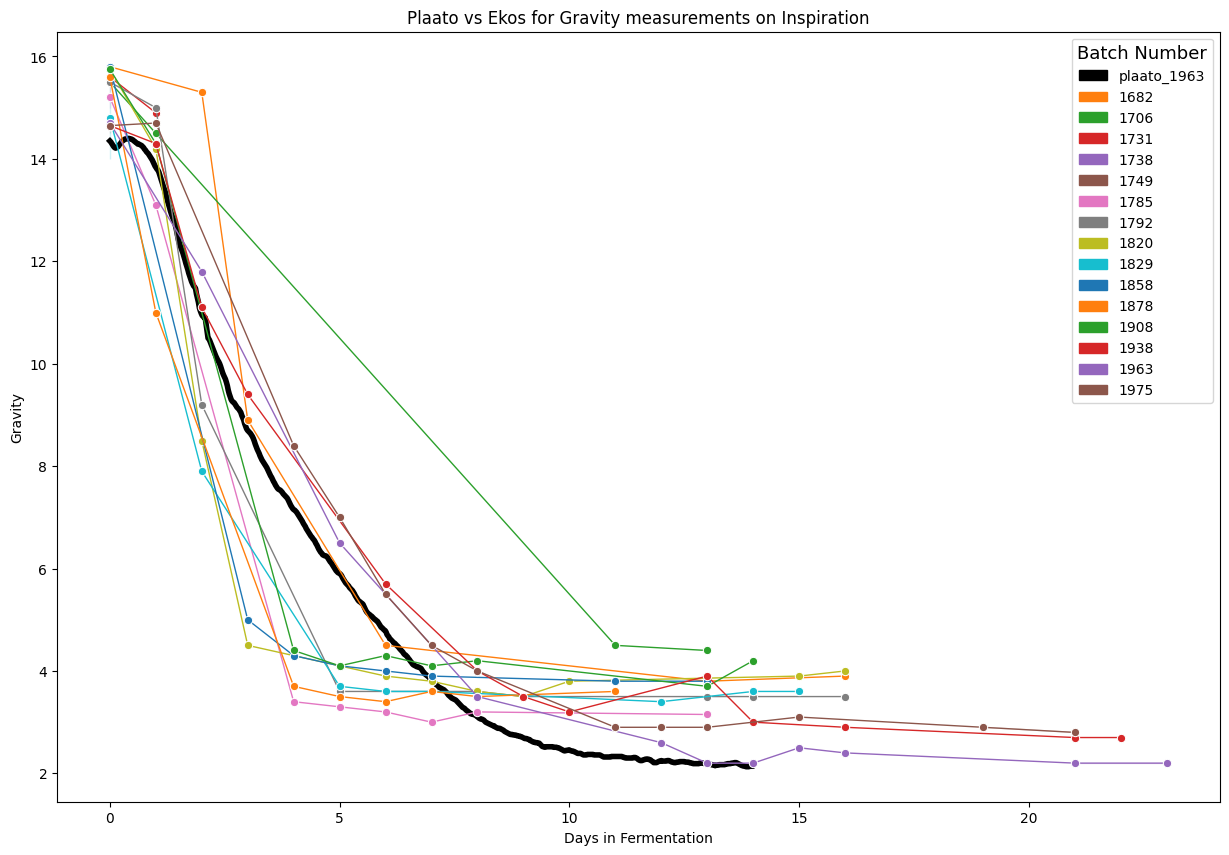

In [48]:
# Gravity measures for indidual batches for Inspiration
plot_plaato_vs_ekos_sku(df_ins_1963_plaato, df_ekos_ins, "Gravity")

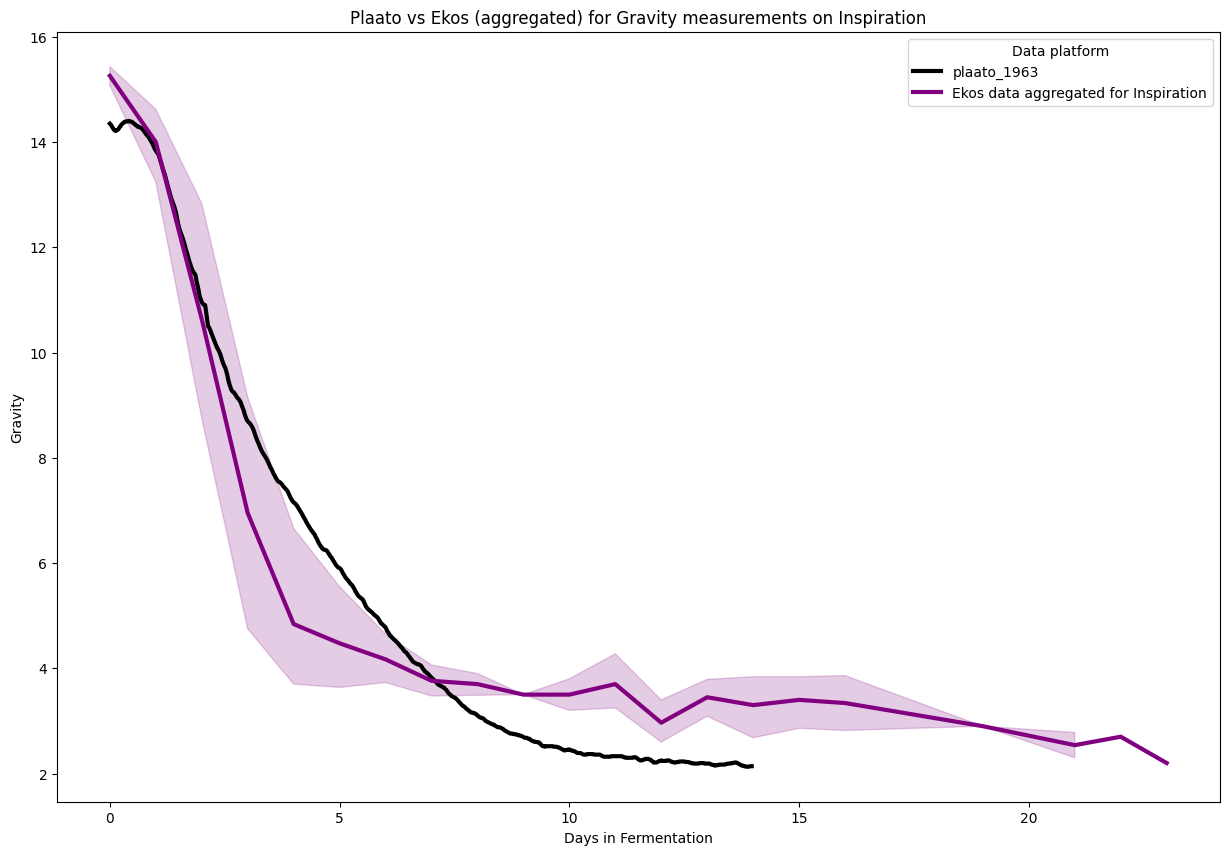

In [49]:
# Aggregated gravity measures for Inspiration
plot_plaato_vs_ekos_sku_aggregated(df_ins_1963_plaato, df_ekos_ins, "Gravity")

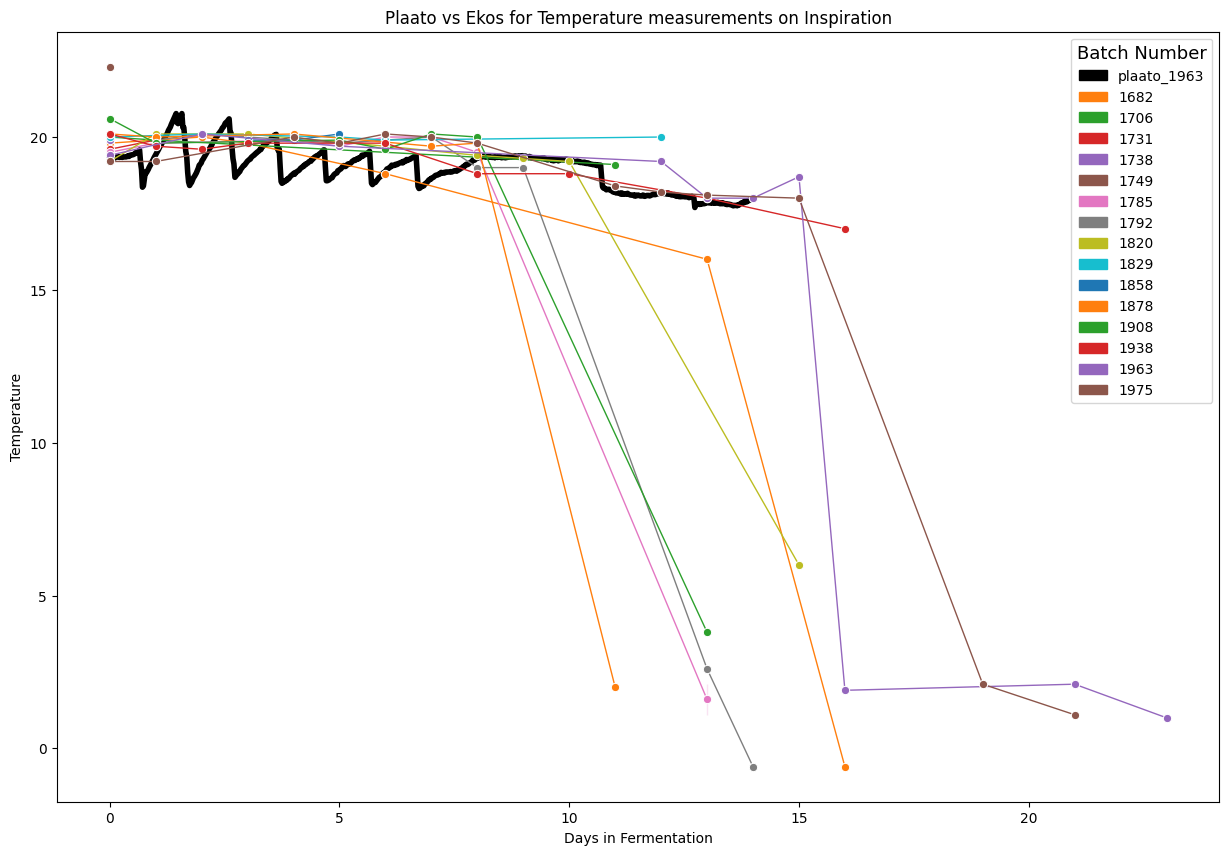

In [50]:
# Temperature measures for indidual batches: Inspiration
plot_plaato_vs_ekos_sku(df_ins_1963_plaato, df_ekos_ins, "Temperature")

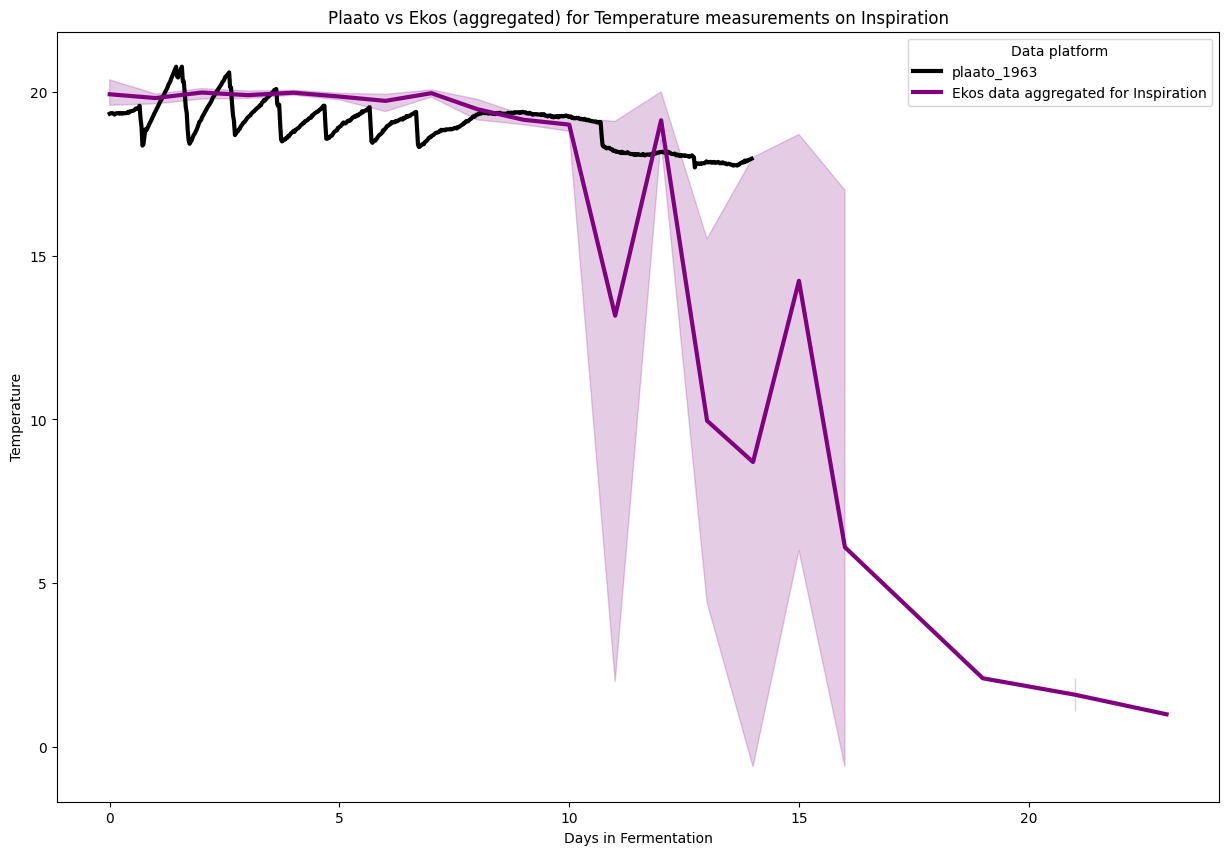

In [51]:
# Aggregated temperature measures for Inspiration
plot_plaato_vs_ekos_sku_aggregated(df_ins_1963_plaato, df_ekos_ins, "Temperature")

#### Presta SKU comparison plots

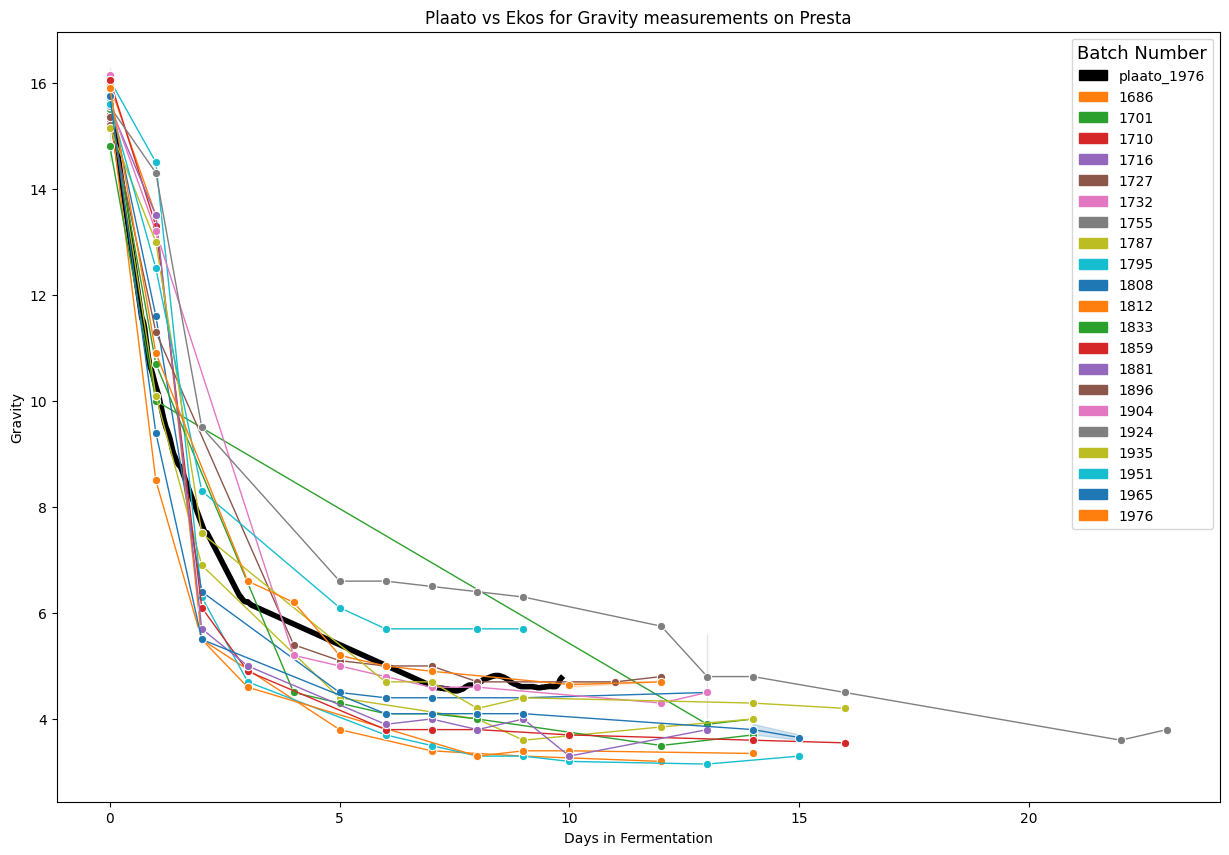

In [52]:
# Individual and aggregated gravity measures for Presta
plot_plaato_vs_ekos_sku(df_pre_1976_plaato, df_ekos_pre, "Gravity")

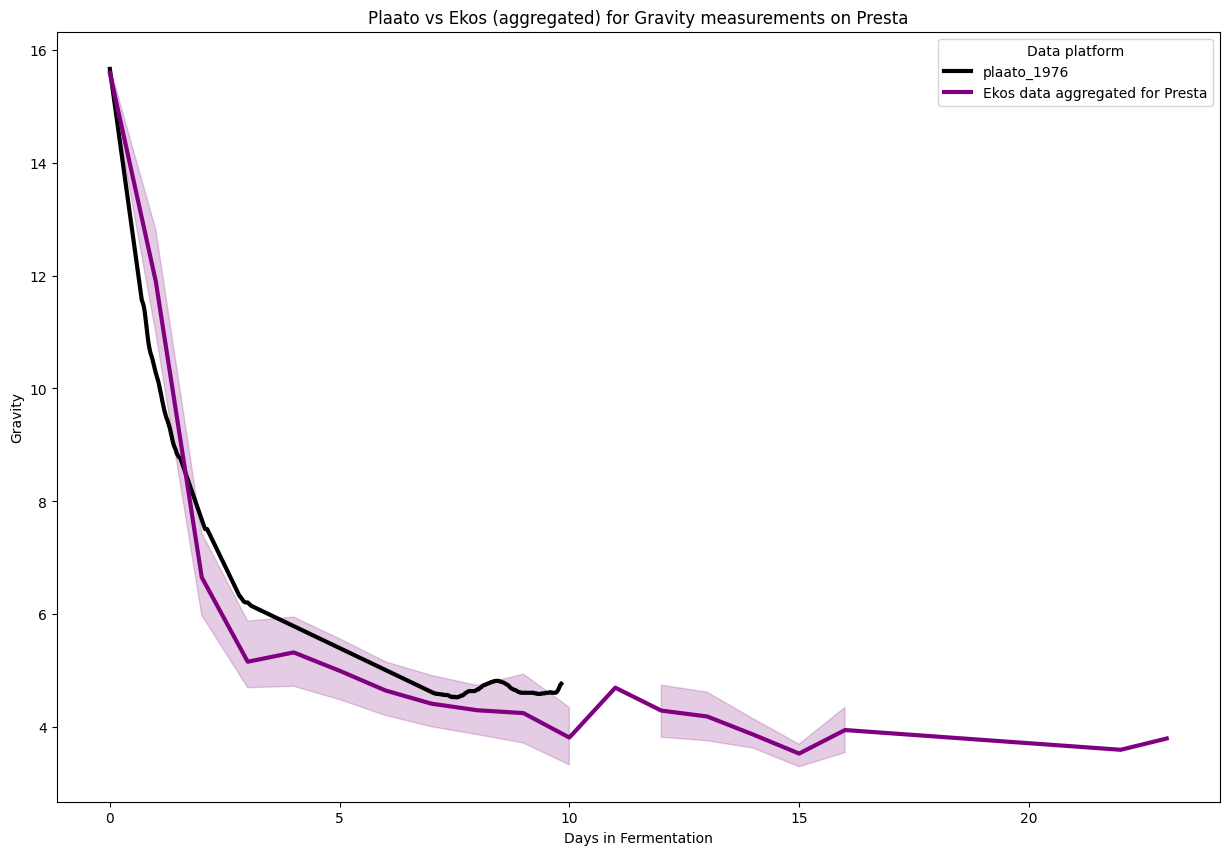

In [53]:
plot_plaato_vs_ekos_sku_aggregated(df_pre_1976_plaato, df_ekos_pre, "Gravity")

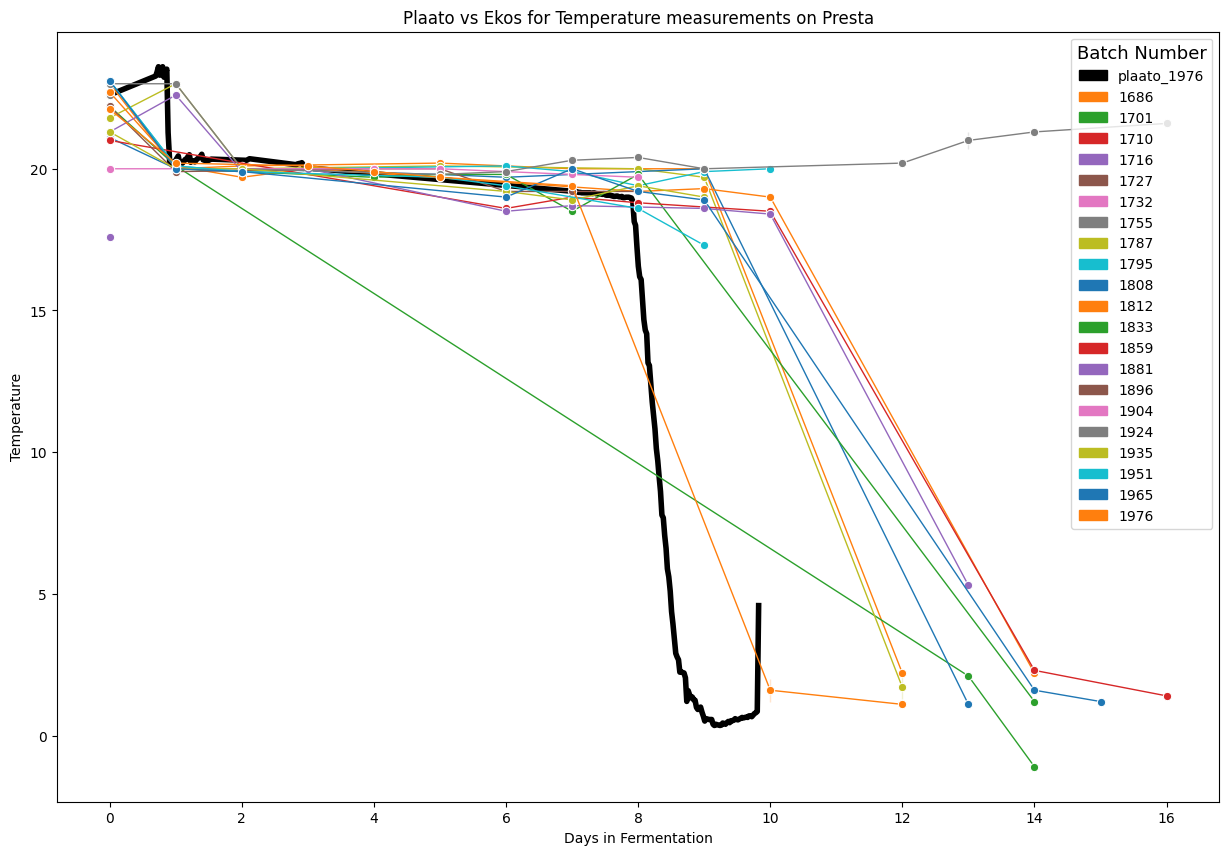

In [54]:
# Individual and aggregated temperature measures for Presta
plot_plaato_vs_ekos_sku(df_pre_1976_plaato, df_ekos_pre, "Temperature")

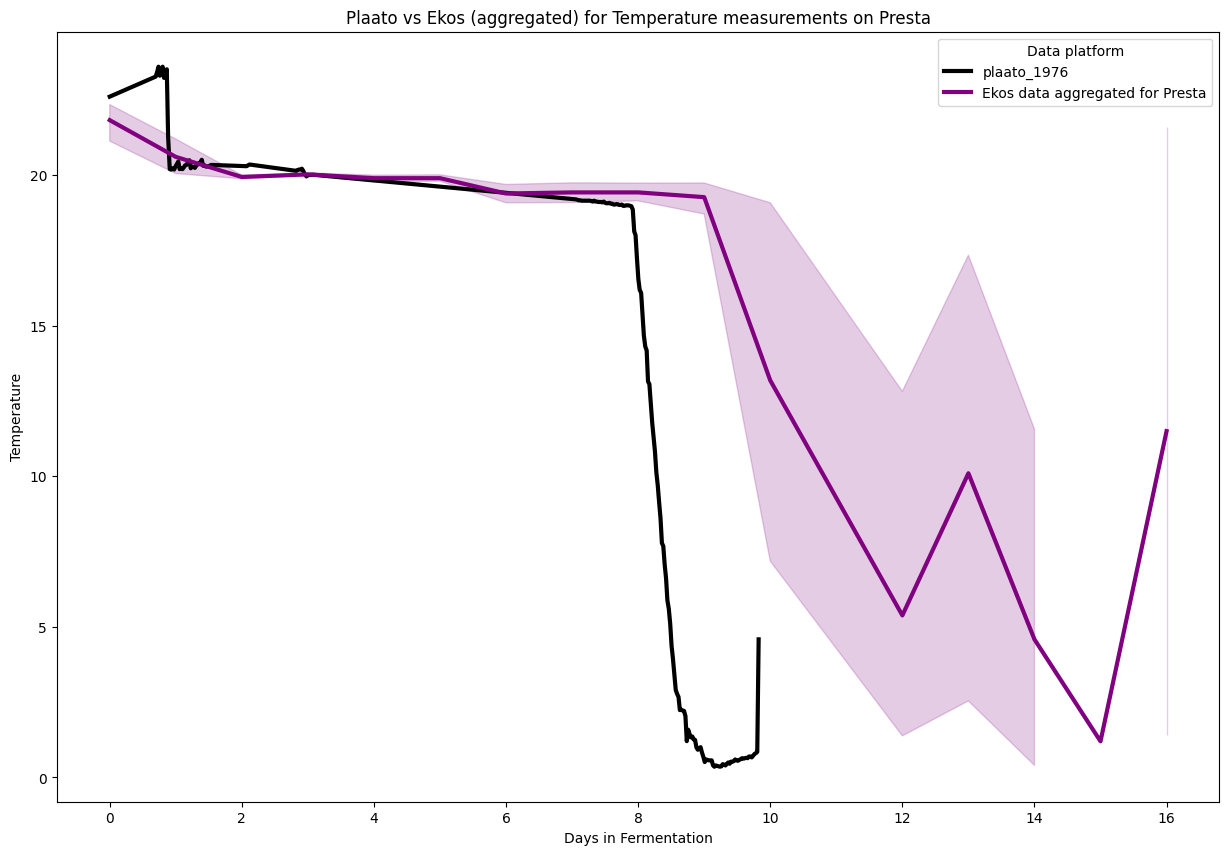

In [55]:
plot_plaato_vs_ekos_sku_aggregated(df_pre_1976_plaato, df_ekos_pre, "Temperature")

#### Bipap SKU comparison plots

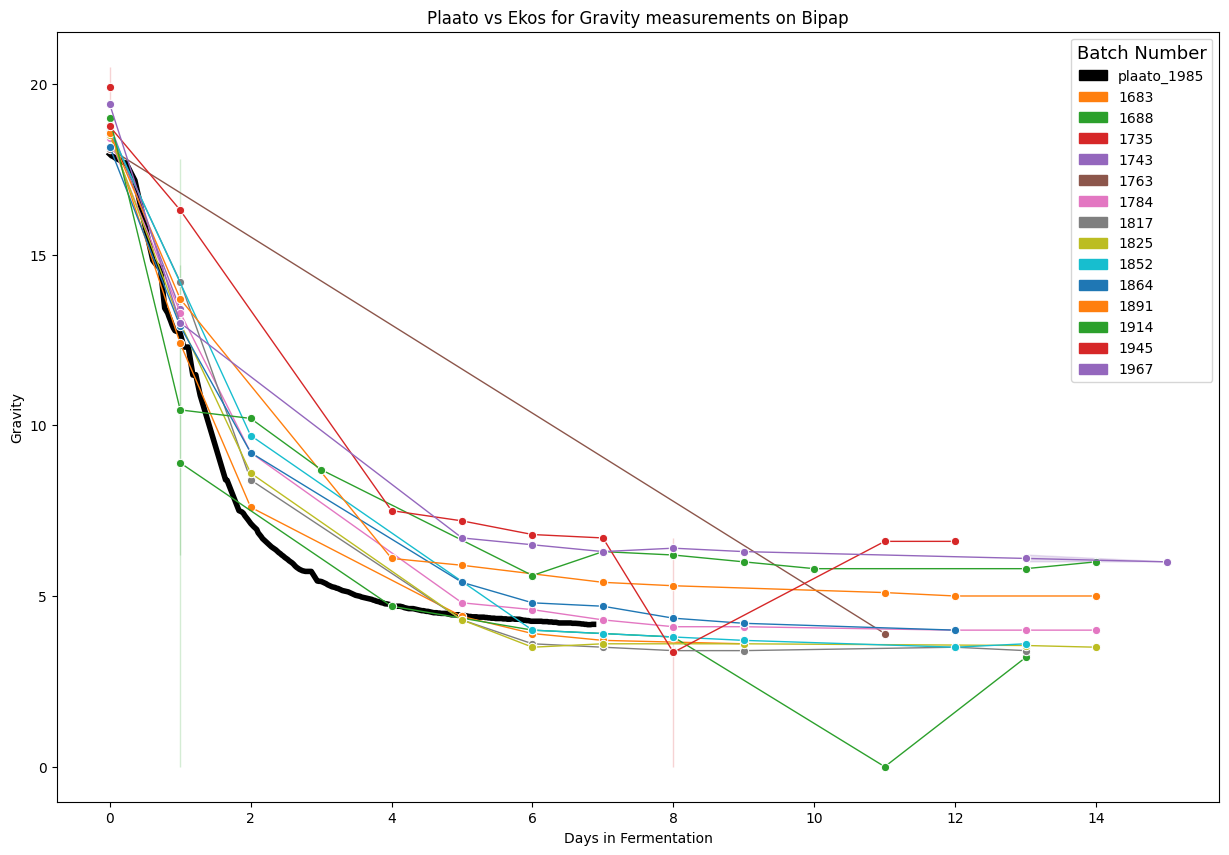

In [56]:
# Individual and aggregated gravity measures for Bipap
plot_plaato_vs_ekos_sku(df_bip_1985_plaato, df_ekos_bip, "Gravity")

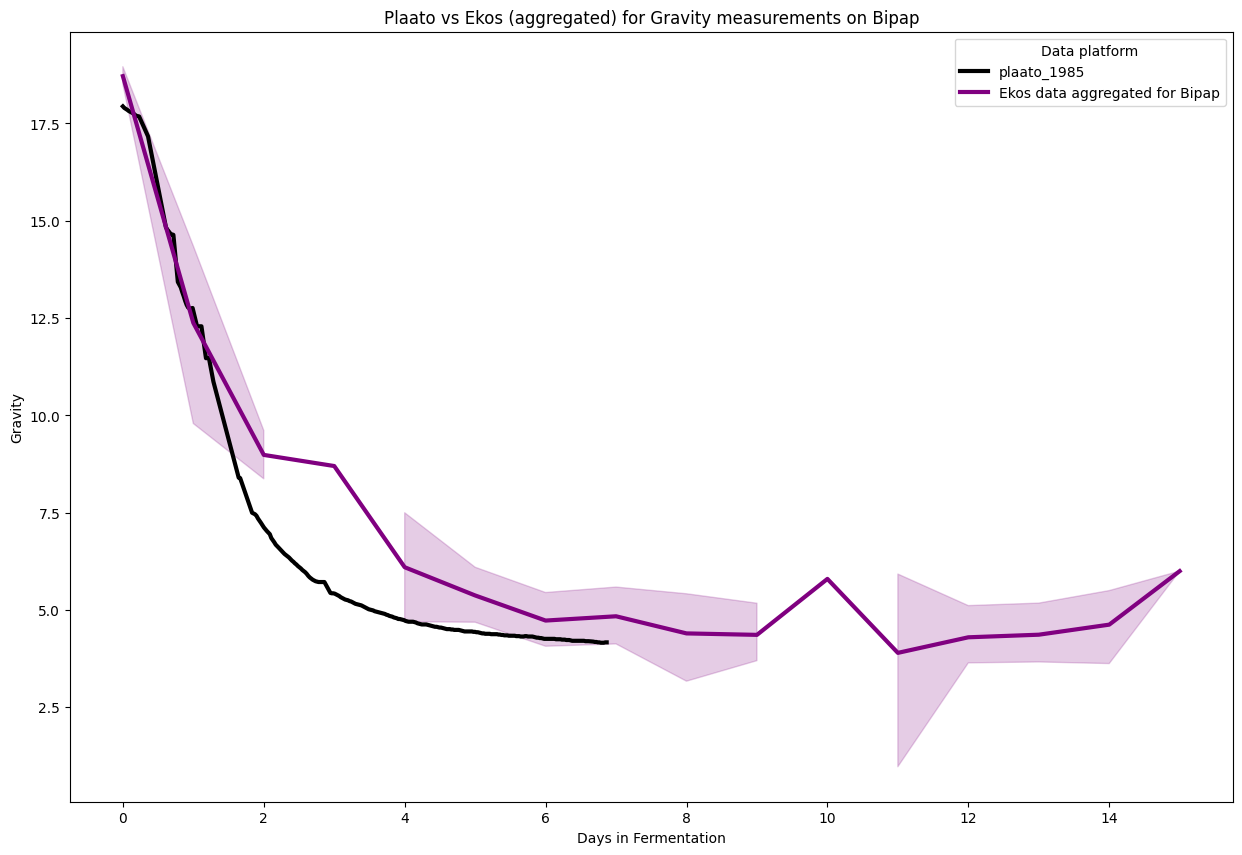

In [57]:
plot_plaato_vs_ekos_sku_aggregated(df_bip_1985_plaato, df_ekos_bip, "Gravity")

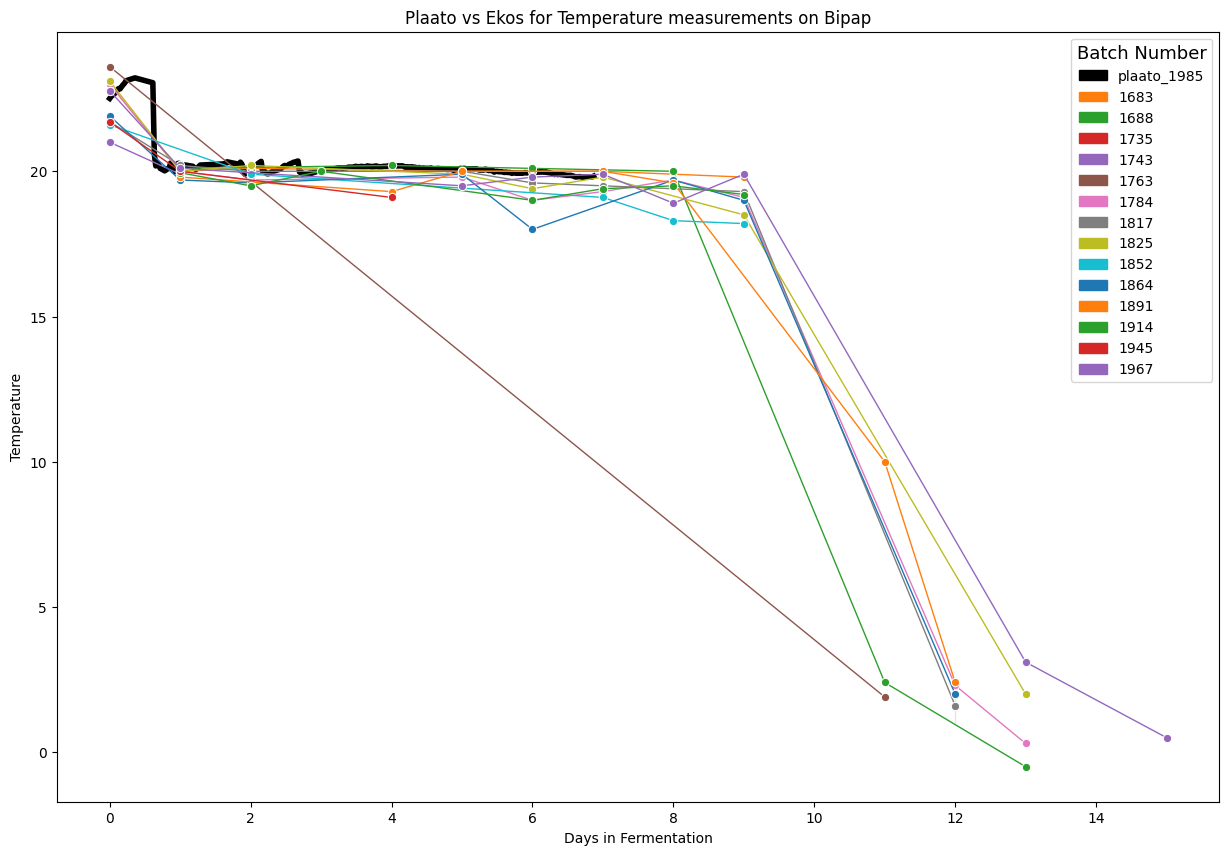

In [58]:
# Individual and aggregated temperature measures for Bipap
plot_plaato_vs_ekos_sku(df_bip_1985_plaato, df_ekos_bip, "Temperature")

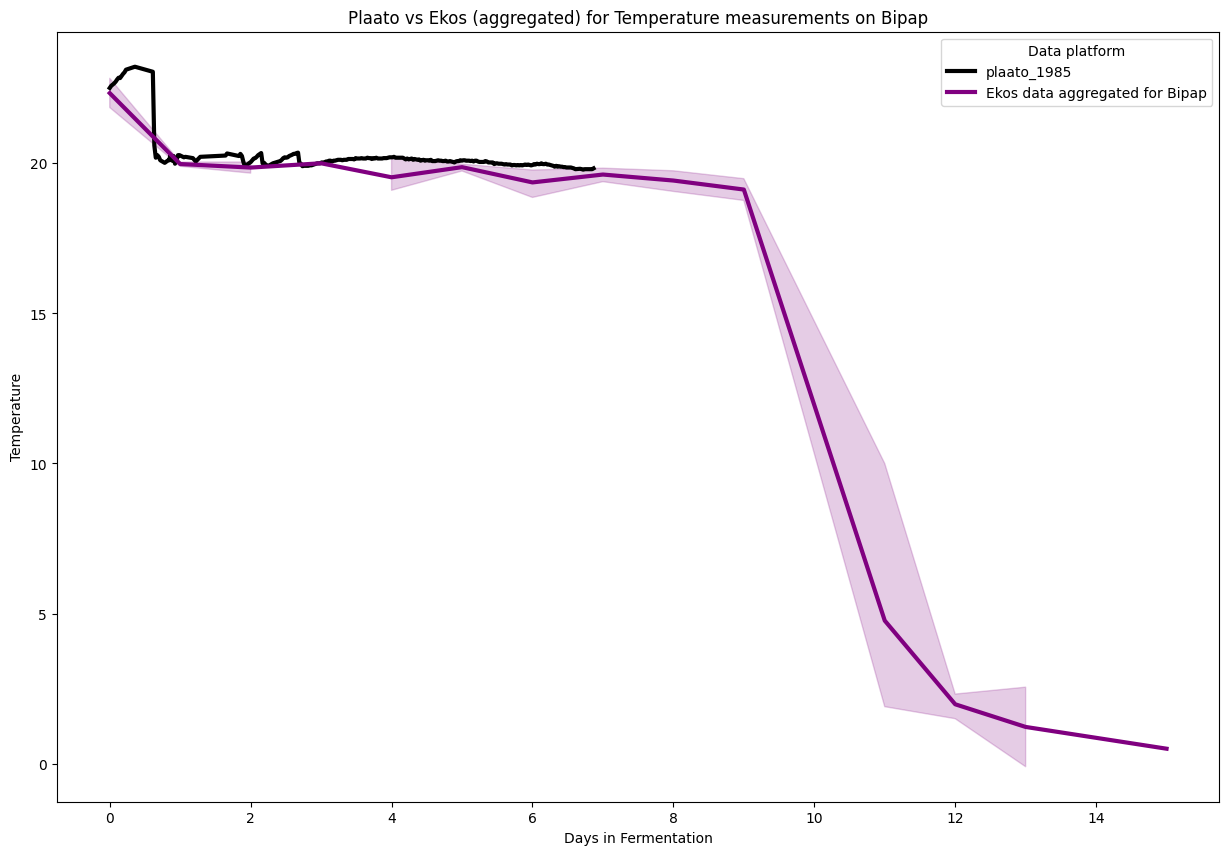

In [59]:
plot_plaato_vs_ekos_sku_aggregated(df_bip_1985_plaato, df_ekos_bip, "Temperature")